# Examining Behavior of SPX Options on Expiration Day

### 1) Data Cleaning and Preparation
- Consolidate intraday minutely data from daily SPX yahoo pulls
- Consolidate VIX intraday prices from daily VIX options files
- Consolidate 0 DTE expiration options from daily SPX options pulls
- Retrieve live minutely data from Alphavantage

### 2) Initial Check of SPX Spot Behavior Intraday
- Test for random walk
    - Check 1 min, 5 min, 10 min, 15 min, 20 min, 30 min intervals on:
        - Entire day
        - Segmented times in the day, e.g., hourly behavior, half-hour behavior, etc.
    - Perform DF test
    - Calculate probability of price movements using volatility windows and simulating price behavior

### 3) Relationship of VIX Intraday to 0 DTE Option IV
- Check if VIX and IV use calendar or trading days to annualize
- Determine Function of Skew using 3rd and 4th moments
- Plot IV surface against strikes and time of day
- Check behavior of IV movement given VIX term structure is in Contango or Backwardation

### 4) Expiration Day Option Pricing
- Implied Binomial Pricing model using probability inferred from option prices
- Monte Carlo using implied binomial probabilities then backing out he IV from simulated option prices
- Use Black Scholes but IV based on VIX intraday or HV from intraday SPX

##### Importing Necessary Modules

In [458]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import pandas.stats.moments as st
import statsmodels.tsa.stattools as ts
from pandas_datareader.data import Options
pd.options.display.float_format = '{:,.4f}'.format

import numpy as np
import datetime as dt
import time

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
%matplotlib inline

from sqlalchemy import *
from sqlalchemy import create_engine
import sqlite3 as sql
from scipy.stats import norm as norm

import os
main_dir = os.getcwd()
os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\RetiredModules')
from helpers import maturities
os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\DataCollection')
cleaned_dir = 'D:\\Options Data\\Monthly DBs'
from yahoo_query import *

def alpha_vantage(ticker, key):
    if key == 0:
        api_key = '5HZEUI5AFJB06BUK'
    else:
        api_key = '6ZAZOL7YF8VPXND7'
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={0}&interval=1min&outputsize=full&apikey={1}&datatype=csv' 
    df = pd.read_csv(url.format(ticker, api_key), index_col = 0).sort_index()
    df.index = pd.to_datetime(df.index)    
    return df

from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
from statsmodels.graphics.tsaplots import plot_acf

def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, len(ts) - 1)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

def hurst_ernie_chan(p):

    variancetau = []; tau = []
    lags = range(2, len(p) - 1)
    
    for lag in lags: 

        #  Write the different lags into a vector to compute a set of tau or lags
        tau.append(lag)

        # Compute the log returns on all days, then compute the variance on the difference in log returns
        # call this pp or the price difference
        pp = subtract(p[lag:], p[:-lag])
        variancetau.append(np.var(pp))

    # we now have a set of tau or lags and a corresponding set of variances.
    #print tau
    #print variancetau

    # plot the log of those variance against the log of tau and get the slope
    m = polyfit(np.log10(tau),np.log10(variancetau),1)

    hurst = m[0] / 2

    return hurst

##### 1) Data Preparation

In [125]:
# Retrieving Data for VIX Term Structure
v1 = pd.read_csv('https://www.quandl.com/api/v3/datasets/CHRIS/CBOE_VX1.csv?api_key=dzmzEExntfap7SNx5p6t', index_col = 0)[['Open','Close']].sort_index()
v2 = pd.read_csv('https://www.quandl.com/api/v3/datasets/CHRIS/CBOE_VX2.csv?api_key=dzmzEExntfap7SNx5p6t', index_col = 0)[['Open','Close']].sort_index()
vix = pd.read_csv('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixcurrent.csv', skiprows=[0], index_col = 0)
vix.index = pd.to_datetime(vix.index)
vix_term = vix.join(v1.join(v2, lsuffix = '_F1', rsuffix = '_F2').dropna()).dropna()
vix_term['Front_Weights'] = np.nan
vix_term['Back_Weights'] = np.nan

for index, row in vix_term.iterrows():
    weights = maturities(index.date())
    front_weight = weights[0]
    back_weight = weights[1]
    vix_term.loc[index, 'Front_Weights'] = front_weight
    vix_term.loc[index, 'Back_Weights'] = back_weight
    
vix_term = vix_term[list(filter(lambda x: 'Open' in x or 'Weight' in x, vix_term.columns.tolist()))]
vix_term['Contango_Ratio'] = vix_term.Front_Weights*(vix_term['VIX Open']/vix_term.Open_F1) + vix_term.Back_Weights*(vix_term.Open_F1/vix_term.Open_F2)
vix_term = vix_term[vix_term.index >= dt.datetime(2018,7,30)]

# Retrieving Data For Intraday SPX and VIX Indices from Local Databases
os.chdir(cleaned_dir)
vix_intraday = pd.read_csv('vix_intraday.csv', index_col = 0).set_index('Quote_Time')
vix_intraday.index = pd.to_datetime(vix_intraday.index)
vix_intraday = vix_intraday[~vix_intraday.index.duplicated(keep='last')].sort_index()

spx_intraday = []
calls_intraday = []
puts_intraday = []

for curr_date in [dt.datetime(2018,x,1) for x in range(7,13)] + [dt.datetime(2019,1,1)]:
    db_name = 'sqlite:///intraday_{0}-{1}.db'.format(curr_date.year,curr_date.month)
    options_engine = create_engine(db_name, echo=False)
    latest_spx = pd.read_sql_query('SELECT * FROM spx_prices', con = options_engine, index_col = 'index')
    latest_spx.index = pd.to_datetime(latest_spx.index)
    spx_intraday.append(latest_spx)
    
    options_query = 'SELECT * FROM spx_{} WHERE DTE = 0'
    
    latest_calls = pd.read_sql_query(options_query.format('calls'), con = options_engine, index_col = 'quoteTime')
    latest_calls.index = pd.to_datetime(latest_calls.index)
    calls_intraday.append(latest_calls)
    
    latest_puts = pd.read_sql_query(options_query.format('puts'), con = options_engine, index_col = 'quoteTime')
    latest_puts.index = pd.to_datetime(latest_puts.index)
    puts_intraday.append(latest_puts)
    
spx_intraday = pd.concat(spx_intraday, axis = 0)
spx_intraday['Date'] = spx_intraday.index.date
calls_intraday = pd.concat(calls_intraday, axis = 0)
puts_intraday = pd.concat(puts_intraday, axis = 0)

# Cleaning SPX Intraday Data
exclusions = spx_intraday.groupby('Date').count()
exclusions = exclusions.reset_index()

exclusion_dates = exclusions[(exclusions['Last'] <= 350) | (exclusions.Last > 391)].Date.tolist()
spx_intraday = spx_intraday[spx_intraday.Date.isin(exclusion_dates) == False]

impute_dates = exclusions[(exclusions.Last != 391) & (exclusions.Date.isin(exclusion_dates) == False)]

model_day = spx_intraday[spx_intraday.Date == dt.date(2018,7,31)].copy()

corrected_df_list = []

for date_to_correct in impute_dates.Date:
    df_to_correct = spx_intraday[spx_intraday.Date == date_to_correct].copy()
    time_delta_adj = df_to_correct.Date.head(1).values[0] - model_day.Date.head(1).values[0]
    
    df_to_join = model_day.copy()
    df_to_join.index = df_to_join.index + time_delta_adj
    del df_to_join['Last'], df_to_join['Date']
    
    df_to_correct = df_to_join.join(df_to_correct)
    df_to_correct.Date = df_to_correct.index.date
    df_to_correct = df_to_correct.fillna(method = 'bfill')
    
    corrected_df_list.append(df_to_correct)
    
corrected_spx_df = pd.concat(corrected_df_list, axis = 0)
spx_intraday = pd.concat([spx_intraday[spx_intraday.Date.isin(impute_dates.Date.tolist()) == False],
                          corrected_spx_df], axis = 0).sort_index()

further_exclusion_dates = [dt.date(2018,10,10), dt.date(2018,9,3), dt.date(2018,12,24),
                           dt.date(2018,12,25)]

spx_intraday = spx_intraday[spx_intraday.Date.isin(further_exclusion_dates) == False]

tol = pd.Timedelta('180 second')
index_intraday = pd.merge_asof(left=spx_intraday,right=vix_intraday[['Underlying_Price']],
                               right_index=True,
                               left_index=True,
                               direction='nearest',
                               tolerance=tol).dropna()
index_intraday.columns = ['SPX','Date','VIX']

##### 2) Initial Check of SPX Spot Behavior Intraday
- Test for random walk
    - Check 1 min, 5 min intervals on:
        - Entire day
        - Segmented times in the day, e.g., hourly behavior, half-hour behavior, etc.
    - Perform DF test
    - Calculate probability of price movements using volatility windows and simulating price behavior

**ADF test for random walk** <br>
- The test statistic is a negative number and thus in order to be significant beyond the critical values, the number must be more negative than these values, i.e. less than the critical values.
- The ADF null hypothesis is that the process is a random walk and thus non mean-reverting (i.e., a high p-value indicates that we fail to reject the null that it is a random walk)
- The output of the Augmented Dickey-Fuller test over a period is as follows:
    - The first value is the calculated test-statistic
    - The second value is the p-value.
    - The fourth is the number of data points in the sample. 
    - The fifth value, the dictionary, contains the critical values of the test-statistic at the 1, 5 and 10 percent values respectively.

**Hurst Exponent Test for Stationarity** <br>
A time series can then be characterised in the following manner:
- H < 0.5 - The time series is mean reverting
- H = 0.5 - The time series is a Geometric Brownian Motion
- H > 0.5 - The time series is trending

**Autocorrelation is highest most often during the times of 9:30 AM to 10:00 AM and 1:00 PM to 2:00 PM** <br>
**Non-mean reverting series occurs most often at 9:30 AM to 10:00 AM and from 1:00 PM to 3:00 PM**

In [431]:
def intraday_autocorr(price_series, curr_date):
    
    day_blocks = [dt.datetime(curr_date.year, curr_date.month, curr_date.day, x) for x in range(9,17)]
    day_blocks = [day_blocks[i:i + 2] for i in range(len(day_blocks) - 1)]
    block_series = [price_series[(price_series.index >= block[0]) & 
                                 (price_series.index <= block[1])] for block in day_blocks]
    
    return [price_series.Last.pct_change().dropna().autocorr()] + [block.Last.pct_change().dropna().autocorr() for block in block_series]

def intraday_ts_tests(price_series, curr_date, use_5min = False):
    
    day_blocks = [dt.datetime(curr_date.year, curr_date.month, curr_date.day, x) for x in range(9,17)]
    day_blocks = [day_blocks[i:i + 2] for i in range(len(day_blocks) - 1)]
    block_series = [price_series[(price_series.index >= block[0]) & 
                                 (price_series.index <= block[1])] for block in day_blocks]
    if use_5min:
        block_series[0] = price_series[(price_series.index <= dt.datetime(curr_date.year,
                                                                          curr_date.month, 
                                                                          curr_date.day, 10, 30))]

    return [(ts.adfuller(price_series.Last)[1], 
             hurst_ernie_chan(price_series.Last))] + [(ts.adfuller(block.Last)[1], 
                                            hurst_ernie_chan(block.Last)) for block in block_series]

def create_stats_df(interval_dict):
    for i, k in enumerate(interval_dict.keys()):
        if i == 0:
            curr_interval_df = pd.DataFrame(interval_dict[k], index = spx_intraday.Date.drop_duplicates())
        else:
            curr_interval_df = curr_interval_df.join(pd.DataFrame(interval_dict[k], index = spx_intraday.Date.drop_duplicates()),
                                                     rsuffix = '_{}'.format(k))

    return curr_interval_df

intervals_1min = {'full_day': {'hurst':[],'adf':[]}, 'timeblock1': {'hurst':[],'adf':[]},
                  'timeblock2': {'hurst':[],'adf':[]}, 'timeblock3': {'hurst':[],'adf':[]},
                  'timeblock4': {'hurst':[],'adf':[]}, 'timeblock5': {'hurst':[],'adf':[]},
                  'timeblock6': {'hurst':[],'adf':[]}}
intervals_5min = {'full_day': {'hurst':[],'adf':[]}, 'timeblock1': {'hurst':[],'adf':[]},
                  'timeblock2': {'hurst':[],'adf':[]}, 'timeblock3': {'hurst':[],'adf':[]},
                  'timeblock4': {'hurst':[],'adf':[]}, 'timeblock5': {'hurst':[],'adf':[]},
                  'timeblock6': {'hurst':[],'adf':[]}}

for curr_date in spx_intraday.Date.drop_duplicates().tolist():

    curr_day_spx = spx_intraday[spx_intraday.Date == curr_date][['Last']]
    curr_5min = curr_day_spx.iloc[::5, :]    
    
    curr_1min_tests = intraday_ts_tests(curr_day_spx, curr_date)
    curr_5min_tests = intraday_ts_tests(curr_5min, curr_date, True)
    
    i = 0
    for k,v in intervals_1min.items():
        intervals_1min[k]['hurst'].append(curr_1min_tests[i][1])
        intervals_1min[k]['adf'].append(curr_1min_tests[i][0])

        i += 1
        
    i = 0
    for k,v in intervals_5min.items():
        intervals_5min[k]['hurst'].append(curr_5min_tests[i][1])
        intervals_5min[k]['adf'].append(curr_5min_tests[i][0])

        i += 1
        
intervals_1min = create_stats_df(intervals_1min)
intervals_5min = create_stats_df(intervals_5min)

In [382]:
adfs_1min = intervals_1min[list(filter(lambda x: 'adf' in x, intervals_1min.columns.tolist()))]
adfs_5min = intervals_5min[list(filter(lambda x: 'adf' in x, intervals_5min.columns.tolist()))]

hurst_1min = intervals_1min[list(filter(lambda x: 'hurst' in x, intervals_1min.columns.tolist()))]
hurst_5min = intervals_5min[list(filter(lambda x: 'hurst' in x, intervals_5min.columns.tolist()))]

idx = ['full_day', 'timeblock1', 'timeblock2', 'timeblock3','timeblock4', 'timeblock5', 'timeblock6']

adf_summary = {'adf_1min':[],
                 'adf_5min':[]}

for col in adfs_1min.columns:
    adf_summary['adf_1min'].append(len(adfs_1min[adfs_1min[col] < 0.05]))
    adf_summary['adf_5min'].append(len(adfs_5min[adfs_5min[col] < 0.05]))

In [391]:
day_blocks = [dt.datetime(curr_date.year, curr_date.month, curr_date.day, x) for x in range(9,17)]
day_blocks = [day_blocks[i:i + 2] for i in range(len(day_blocks) - 1)]
time_blocks = [str([x.strftime('%H:%M') for x in block]).replace('[','').replace(']','').replace("'",'') for block in day_blocks]

hurst_1min_summary = {'mr_counts':[],
                      'gbm_counts':[],
                      'trend_counts':[]}

hurst_5min_summary = {'mr_counts':[],
                      'gbm_counts':[],
                      'trend_counts':[]}

for col in hurst_1min.columns:
    hurst_1min_summary['mr_counts'].append(len(hurst_1min[hurst_1min[col] < 0.4]))
    hurst_1min_summary['trend_counts'].append(len(hurst_1min[hurst_1min[col] > 0.6]))
    hurst_1min_summary['gbm_counts'].append(len(hurst_1min[(hurst_1min[col] <= 0.6) & (hurst_1min[col] >= 0.4)]))
    
for col in hurst_5min.columns:
    hurst_5min_summary['mr_counts'].append(len(hurst_5min[hurst_5min[col] < 0.4]))
    hurst_5min_summary['trend_counts'].append(len(hurst_5min[hurst_5min[col] > 0.6]))
    hurst_5min_summary['gbm_counts'].append(len(hurst_5min[(hurst_5min[col] <= 0.6) & (hurst_5min[col] >= 0.4)]))

pd.DataFrame(adf_summary,index = idx).join(pd.DataFrame(hurst_1min_summary,index = idx),
                                           rsuffix = '_hurst1').join(pd.DataFrame(hurst_5min_summary,index = idx),
                                                                     rsuffix = '_hurst5')

adf_1min  adf_5min  gbm_counts  mr_counts  trend_counts  \
full_day          12        12           0        108             0   
timeblock1        17         9           0        107             0   
timeblock2         7         3           0        107             0   
timeblock3         8         6           0        107             0   
timeblock4        12         3           0        108             0   
timeblock5        12        13           0        108             0   
timeblock6         5         7           0        107             0   

            gbm_counts_hurst5  mr_counts_hurst5  trend_counts_hurst5  
full_day                    0               108                    0  
timeblock1                  1               107                    0  
timeblock2                  0               107                    0  
timeblock3                  0               108                    0  
timeblock4                  0               108                    0  
timeblock5                  0               108                    0  
timeblock6                  0               107                    0

In [432]:
autocorr_idx = idx + ['timeblock7']

intervals_1min_autocorr = {k:[] for k in autocorr_idx}
intervals_5min_autocorr = {k:[] for k in autocorr_idx}

for curr_date in spx_intraday.Date.drop_duplicates().tolist():

    curr_day_spx = spx_intraday[spx_intraday.Date == curr_date][['Last']]
    curr_5min = curr_day_spx.iloc[::5, :]    

    autocorrs_1min = intraday_autocorr(curr_day_spx, curr_date)
    autocorrs_5min = intraday_autocorr(curr_5min, curr_date)
    
    for i,v in enumerate(autocorrs_1min):
        intervals_1min_autocorr[autocorr_idx[i]].append(v)
    
    for i,v in enumerate(autocorrs_5min):
        intervals_5min_autocorr[autocorr_idx[i]].append(v)

intervals_1min_autocorr = pd.DataFrame(intervals_1min_autocorr, index = spx_intraday.Date.drop_duplicates().tolist())
intervals_5min_autocorr = pd.DataFrame(intervals_5min_autocorr, index = spx_intraday.Date.drop_duplicates().tolist())

In [450]:
autocorr_1min_summary = {k:[] for k in intervals_1min_autocorr.columns}
autocorr_5min_summary = {k:[] for k in intervals_5min_autocorr.columns}

for col in intervals_1min_autocorr.columns:
    autocorr_1min_summary[col].append(len(intervals_1min_autocorr[abs(intervals_1min_autocorr[col]) > 0.3]))
    autocorr_5min_summary[col].append(len(intervals_5min_autocorr[abs(intervals_5min_autocorr[col]) > 0.3]))

In [451]:
pd.DataFrame(autocorr_1min_summary, 
             index = ['interval_1min']).T.join(pd.DataFrame(autocorr_5min_summary,
                                                            index = ['interval_5min']).T)

interval_1min  interval_5min
full_day                0              0
timeblock1             11             67
timeblock2              3             28
timeblock3              2             40
timeblock4              2             25
timeblock5              2             27
timeblock6              3             30
timeblock7              4             37

In [645]:
spx = alpha_vantage('SPX',1)
vix = alpha_vantage('VIX',1)

In [646]:
for i in range(20, len(spx[spx.index >= dt.datetime(max(spx.index).year,max(spx.index).month,max(spx.index).day)]), 20):
    print('Lookback {} Periods:'.format(i))
    print('ADF:')
    print(ts.adfuller(spx.close.tail(i)))
    print('Hurst:')
    print(hurst_ernie_chan(spx.close.tail(i)))
    print('Autocorr:')
    print(spx.close.tail(i).pct_change().autocorr())
    print('')

Lookback 20 Periods:
ADF:
(0.0, 0.95853208606005602, 9, 10, {'1%': -4.3315729999999997, '5%': -3.2329500000000002, '10%': -2.7486999999999999}, -533.17626650718421)
Hurst:
-0.610212006056
Autocorr:
-0.190276250881

Lookback 40 Periods:
ADF:
(-3.304834177709953, 0.014663764648188794, 0, 39, {'1%': -3.6103996013081812, '5%': -2.9391089458689459, '10%': -2.6080629651545038}, 56.957555503273042)
Hurst:
-0.359185023813
Autocorr:
-0.158807361092

Lookback 60 Periods:
ADF:
(-3.1168139643485624, 0.025333644819705053, 0, 59, {'1%': -3.5463945337644063, '5%': -2.9119394093846012, '10%': -2.5936515282964665}, 85.986932987823337)
Hurst:
-0.066029704157
Autocorr:
-0.0991738730108

Lookback 80 Periods:
ADF:
(-1.6821079680829807, 0.44035376431708484, 0, 79, {'1%': -3.5159766913976376, '5%': -2.8988857034839031, '10%': -2.5866935058484217}, 111.84184967600649)
Hurst:
-0.179221156076
Autocorr:
-0.0666110634904

Lookback 100 Periods:
ADF:
(-1.3144445901362725, 0.62253825996117751, 2, 97, {'1%': -3.49963

In [647]:
curr_vix = vix[vix.index >= dt.datetime(max(vix.index).year,max(vix.index).month,max(vix.index).day)][['close']]
close_time = dt.datetime(curr_vix.index[0].year,curr_vix.index[0].month,curr_vix.index[0].day,
                         16)
curr_vix['TimeToExpiration'] = (close_time - curr_vix.index).seconds/60/390
curr_vix['Calendar'] = 365/curr_vix['TimeToExpiration']
curr_vix['Trading'] = 252/curr_vix['TimeToExpiration']
curr_vix['Calendar'] = curr_vix['close']/np.sqrt(curr_vix['Calendar'])/100
curr_vix['Trading'] = curr_vix['close']/np.sqrt(curr_vix['Trading'])/100
curr_vix = curr_vix.join(spx.close, how = 'left', rsuffix = '_spx')
# curr_vix['CalendarUB'] = curr_vix.close_spx*(1 + curr_vix.Calendar)
# curr_vix['CalendarLB'] = curr_vix.close_spx*(1 - curr_vix.Calendar)
curr_vix['TradingUB'] = curr_vix.close_spx*(1 + curr_vix.Trading)
curr_vix['TradingLB'] = curr_vix.close_spx*(1 - curr_vix.Trading)
curr_vix.tail(50)

close  TimeToExpiration  Calendar  Trading  close_spx  \
timestamp                                                                     
2019-01-14 14:36:00 19.0700            0.2154    0.0046   0.0056 2,583.7000   
2019-01-14 14:37:00 19.0500            0.2128    0.0046   0.0055 2,583.9600   
2019-01-14 14:38:00 19.0000            0.2103    0.0046   0.0055 2,583.9399   
2019-01-14 14:39:00 18.9800            0.2077    0.0045   0.0054 2,583.2400   
2019-01-14 14:40:00 18.9800            0.2051    0.0045   0.0054 2,583.3899   
2019-01-14 14:41:00 18.9700            0.2026    0.0045   0.0054 2,583.7200   
2019-01-14 14:42:00 18.9500            0.2000    0.0044   0.0053 2,583.5300   
2019-01-14 14:43:00 18.9300            0.1974    0.0044   0.0053 2,584.5901   
2019-01-14 14:44:00 18.8800            0.1949    0.0044   0.0053 2,584.6399   
2019-01-14 14:45:00 18.8800            0.1923    0.0043   0.0052 2,585.1101   
2019-01-14 14:46:00 18.8500            0.1897    0.0043   0.0052 2,584.8999   
2019-01-14 14:47:00 18.8300            0.1872    0.0043   0.0051 2,585.2300   
2019-01-14 14:48:00 18.8300            0.1846    0.0042   0.0051 2,585.8799   
2019-01-14 14:49:00 18.7900            0.1821    0.0042   0.0051 2,586.1399   
2019-01-14 14:50:00 18.7600            0.1795    0.0042   0.0050 2,586.1101   
2019-01-14 14:51:00 18.7600            0.1769    0.0041   0.0050 2,586.1699   
2019-01-14 14:52:00 18.7600            0.1744    0.0041   0.0049 2,586.1201   
2019-01-14 14:53:00 18.7700            0.1718    0.0041   0.0049 2,586.6201   
2019-01-14 14:54:00 18.7500            0.1692    0.0040   0.0049 2,586.6699   
2019-01-14 14:55:00 18.7700            0.1667    0.0040   0.0048 2,586.6201   
2019-01-14 14:56:00 18.7600            0.1641    0.0040   0.0048 2,587.0801   
2019-01-14 14:58:00 18.7000            0.1590    0.0039   0.0047 2,588.0601   
2019-01-14 14:59:00 18.7100            0.1564    0.0039   0.0047 2,588.2700   
2019-01-14 15:00:00 18.7200            0.1538    0.0038   0.0046 2,588.2600   
2019-01-14 15:01:00 18.7500            0.1513    0.0038   0.0046 2,588.0701   
2019-01-14 15:02:00 18.7400            0.1487    0.0038   0.0046 2,587.5400   
2019-01-14 15:03:00 18.7700            0.1462    0.0038   0.0045 2,587.0801   
2019-01-14 15:04:00 18.7900            0.1436    0.0037   0.0045 2,587.2800   
2019-01-14 15:05:00 18.7800            0.1410    0.0037   0.0044 2,587.1399   
2019-01-14 15:06:00 18.7900            0.1385    0.0037   0.0044 2,587.2800   
2019-01-14 15:07:00 18.7700            0.1359    0.0036   0.0044 2,587.6201   
2019-01-14 15:08:00 18.7400            0.1333    0.0036   0.0043 2,586.7800   
2019-01-14 15:09:00 18.7900            0.1308    0.0036   0.0043 2,587.5000   
2019-01-14 15:10:00 18.7700            0.1282    0.0035   0.0042 2,587.4900   
2019-01-14 15:11:00 18.7700            0.1256    0.0035   0.0042 2,587.4800   
2019-01-14 15:12:00 18.7700            0.1231    0.0034   0.0041 2,587.2400   
2019-01-14 15:13:00 18.7700            0.1205    0.0034   0.0041 2,587.0400   
2019-01-14 15:14:00 18.7700            0.1179    0.0034   0.0041 2,585.6599   
2019-01-14 15:15:00 18.7800            0.1154    0.0033   0.0040 2,585.5000   
2019-01-14 15:16:00 18.8000            0.1128    0.0033   0.0040 2,585.3799   
2019-01-14 15:17:00 18.7900            0.1103    0.0033   0.0039 2,586.4700   
2019-01-14 15:18:00 18.7400            0.1077    0.0032   0.0039 2,586.3799   
2019-01-14 15:19:00 18.7400            0.1051    0.0032   0.0038 2,586.2200   
2019-01-14 15:20:00 18.7500            0.1026    0.0031   0.0038 2,586.0701   
2019-01-14 15:21:00 18.7700            0.1000    0.0031   0.0037 2,586.7100   
2019-01-14 15:22:00 18.7300            0.0974    0.0031   0.0037 2,586.7300   
2019-01-14 15:23:00 18.7300            0.0949    0.0030   0.0036 2,586.3799   
2019-01-14 15:24:00 18.7700            0.0923    0.0030   0.0036 2,587.8701   
2019-01-14 15:25:00 18.7100            0.0897    0.0029   0.0035 2,587.5

In [650]:
curr_spx = spx[spx.index >= dt.datetime(max(spx.index).year,max(spx.index).month,max(spx.index).day)][['close']]
close_time = dt.datetime(curr_spx.index[0].year,curr_spx.index[0].month,curr_spx.index[0].day,
                         16)
curr_spx['TimeToExpiration'] = (close_time - curr_spx.index).seconds/60/390
curr_spx['VIX'] = 18.88
curr_spx['Calendar'] = 365/curr_spx['TimeToExpiration']
curr_spx['Trading'] = 252/curr_spx['TimeToExpiration']
curr_spx['Calendar'] = curr_spx['VIX']/np.sqrt(curr_spx['Calendar'])/100
curr_spx['Trading'] = curr_spx['VIX']/np.sqrt(curr_spx['Trading'])/100
curr_spx['TradingUB'] = curr_spx.close*(1 + curr_spx.Trading)
curr_spx['TradingLB'] = curr_spx.close*(1 - curr_spx.Trading)
curr_spx

close  TimeToExpiration     VIX  Calendar  Trading  \
timestamp                                                                     
2019-01-14 09:31:00 2,574.7200            0.9974 18.8800    0.0099   0.0119   
2019-01-14 09:32:00 2,573.8799            0.9949 18.8800    0.0099   0.0119   
2019-01-14 09:33:00 2,572.0801            0.9923 18.8800    0.0098   0.0118   
2019-01-14 09:34:00 2,571.6399            0.9897 18.8800    0.0098   0.0118   
2019-01-14 09:35:00 2,570.8701            0.9872 18.8800    0.0098   0.0118   
2019-01-14 09:36:00 2,570.7000            0.9846 18.8800    0.0098   0.0118   
2019-01-14 09:37:00 2,571.6001            0.9821 18.8800    0.0098   0.0118   
2019-01-14 09:38:00 2,573.7600            0.9795 18.8800    0.0098   0.0118   
2019-01-14 09:39:00 2,574.4800            0.9769 18.8800    0.0098   0.0118   
2019-01-14 09:40:00 2,575.5400            0.9744 18.8800    0.0098   0.0117   
2019-01-14 09:41:00 2,577.9600            0.9718 18.8800    0.0097   0.0117   
2019-01-14 09:42:00 2,578.1399            0.9692 18.8800    0.0097   0.0117   
2019-01-14 09:43:00 2,579.2500            0.9667 18.8800    0.0097   0.0117   
2019-01-14 09:44:00 2,578.9700            0.9641 18.8800    0.0097   0.0117   
2019-01-14 09:45:00 2,578.2300            0.9615 18.8800    0.0097   0.0117   
2019-01-14 09:46:00 2,578.5801            0.9590 18.8800    0.0097   0.0116   
2019-01-14 09:47:00 2,578.4500            0.9564 18.8800    0.0097   0.0116   
2019-01-14 09:48:00 2,578.8999            0.9538 18.8800    0.0097   0.0116   
2019-01-14 09:49:00 2,577.6499            0.9513 18.8800    0.0096   0.0116   
2019-01-14 09:50:00 2,577.4600            0.9487 18.8800    0.0096   0.0116   
2019-01-14 09:51:00 2,578.1201            0.9462 18.8800    0.0096   0.0116   
2019-01-14 09:52:00 2,578.1299            0.9436 18.8800    0.0096   0.0116   
2019-01-14 09:53:00 2,580.0901            0.9410 18.8800    0.0096   0.0115   
2019-01-14 09:54:00 2,580.8101            0.9385 18.8800    0.0096   0.0115   
2019-01-14 09:55:00 2,580.0500            0.9359 18.8800    0.0096   0.0115   
2019-01-14 09:56:00 2,579.4800            0.9333 18.8800    0.0095   0.0115   
2019-01-14 09:57:00 2,578.2200            0.9308 18.8800    0.0095   0.0115   
2019-01-14 09:58:00 2,577.7000            0.9282 18.8800    0.0095   0.0115   
2019-01-14 09:59:00 2,577.1599            0.9256 18.8800    0.0095   0.0114   
2019-01-14 10:00:00 2,578.5200            0.9231 18.8800    0.0095   0.0114   
...                        ...               ...     ...       ...      ...   
2019-01-14 15:11:00 2,587.4800            0.1256 18.8800    0.0035   0.0042   
2019-01-14 15:12:00 2,587.2400            0.1231 18.8800    0.0035   0.0042   
2019-01-14 15:13:00 2,587.0400            0.1205 18.8800    0.0034   0.0041   
2019-01-14 15:14:00 2,585.6599            0.1179 18.8800    0.0034   0.0041   
2019-01-14 15:15:00 2,585.5000            0.1154 18.8800    0.0034   0.0040   
2019-01-14 15:16:00 2,585.3799            0.1128 18.8800    0.0033   0.0040   
2019-01-14 15:17:00 2,586.4700            0.1103 18.8800    0.0033   0.0039   
2019-01-14 15:18:00 2,586.3799            0.1077 18.8800    0.0032   0.0039   
2019-01-14 15:19:00 2,586.2200            0.1051 18.8800    0.0032   0.0039   
2019-01-14 15:20:00 2,586.0701            0.1026 18.8800    0.0032   0.0038   
2019-01-14 15:21:00 2,586.7100            0.1000 18.8800    0.0031   0.0038   
2019-01-14 15:22:00 2,586.7300            0.0974 18.8800    0.0031   0.0037   
2019-01-14 15:23:00 2,586.3799            0.0949 18.8800    0.0030   0.0037   
2019-01-14 15:24:00 2,587.8701            0.0923 18.8800    0.0030   0.0036   
2019-01-14 15:25:00 2,587.5601            0.0897 18.8800    0.0030   0.0036   
2019-01-14 15:26:00 2,586.7400            0.0872 18.8800    0.0029   0.0035   
2019-01-14 15:27:00 2,586.9500            0.0846 18.8800    0.0029   0.0035   
2019-01-14 15:28:00 2,587.2300            0.0821 18.8800    0.0028   0.0034

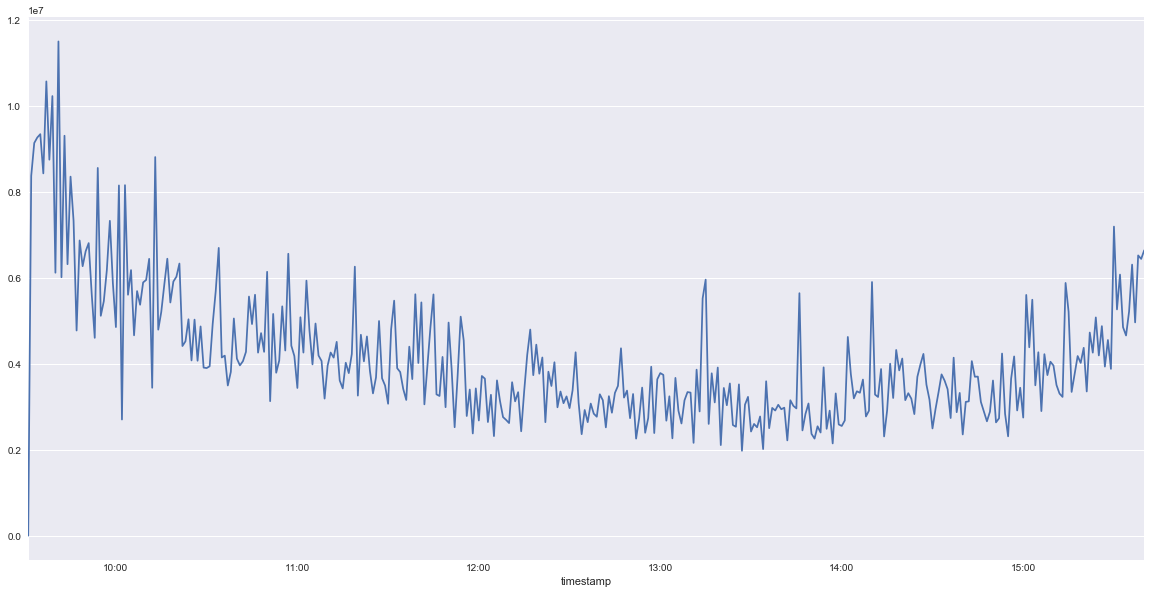

In [649]:
spx[spx.index >= dt.datetime(max(spx.index).year,max(spx.index).month,max(spx.index).day)].volume.plot(figsize = (20,10))